<a href="https://colab.research.google.com/github/kjamesmcgraw/PSY_7500_Final/blob/main/Final_KJM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Comparison of the Linguistic Complexity of Job Descriptions in Various Fields**

**1 Introduction**

Natural language processing methods are increasingly used to process and filter applicants to available roles, as well as identify potential jobs for those seeking a new role [2, 3]. However, Rojas-Galeano et al., (2022) note that resume-based research using natural language processing (NLP) and text analytics is underdeveloped relative to other domains for applying artificial intelligence [5]. Furthermore, they emphasize that while computer-based job-worker data utilization efforts have existed for decades, it is in the last 5-7 years that NLP tools have been used for recommender systems matching employers and employees, rather than just personnel or recruiting information systems.

While the recent literature on resume matching models robustly describes the NLP methods used to pair individuals with roles or roles with individuals, these studies are often completed within a single defined occupational sector. This within-field focus is rarely explicit, but is clear in the description of the data used in such studies. For example, Alsaif and colleagues focused on the roles of Data Scientist, Data Engineer, Java Developer, and Back-end Developer; other research teams describe testing their models within the Computer Science field or motivated research through the intricacies of IT hiring and need to better parse hard and soft data skills [3, 4]. The reliability and validity of these bi-directional matching models is practically significant for those hiring or searching within a single field, where terms are presumed to be domain-specific (or at least shared within the domain). Within-sector resume-job matching research raises questions about the extent to which these models are applicable only in their intra-field context–that is, whether resumes in different fields are distinguishable by linguistic features.

As such, I am interested in the extent to which resumes’ linguistic features are shared across clusters and macro-sectors or are idiosyncratic to specific clusters [1]. Specifically, I ask if there are career cluster groups which are identifiable by the term frequencies of resumes within that group or if term frequencies are common across resumes, regardless of career cluster group. Understanding potential differences that distinguish job descriptions within select clusters from descriptions in other fields–or, on the contrary, commonalities in role descriptions across clusters–are relevant for understanding the applicability of applicant-job matching models developed within select fields to the labor market more broadly. If terms are found to be common across cluster groups and macro-sectors, matching models developed in a discrete context may be more widely applicable.

Therefore, I compare the term frequency–inverse document frequency values of the open-ended descriptions that individuals write to explain their job roles, responsibilities, and successes in their resumes across the six cluster groups and two macro-sectors.

*1.1 Research Question*
The following research questions guide this study:
- How do key terms in resumes differ among the career cluster groups?
- To what extent do key terms in resumes predict the resume belonging in a cross-cutting or discrete cluster group?

*1.2 Hypothesis*

I hypothesize that the macro-sector capturing the 4 discrete sectors will have higher classification accuracy than the cross-cutting macro-sector.

In [1]:
# Set working directory
%%capture
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/_LPO/7500SPED_NLP/Proj')

# Import packages used in analysis
# Regular expressions and pandas for data management
import re
import pandas as pd

# spaCy for NLP processing
import spacy
nlp = spacy.load("en_core_web_sm") #defining nlp for processing text later

# gensim for bag-of-words creation
!pip install gensim
import gensim

# Packages for analysis and visualization
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from bs4 import BeautifulSoup
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from IPython.display import Image, display # to display career framework

# Load data
resume_data = pd.read_csv('Resume.csv', encoding = "utf-8")
# print(resume_data.head())

**2 Data**

The dataset contains 2484 blinded resumes scraped from LiveCareer.com, a resume support site. That is, names, locations, and firms are removed; educational institutions are present. In the raw data, each row represents a unique resume with columns for the string content of the resume, html content of the resume, and a single categorical tag for field. Each unique resume is labelled with a single career field for the most recent job experience listed on the resume. Twenty-four field tags exist in the raw data: accountant, teacher, sales, public relations, information technology, human resources, healthcare, fitness, finance, engineering, digital media, designer, consultant, construction, chef, business development, business process outsourcing, banking, aviation, automobile, arts, apparel, agriculture, and advocate. All resumes in the dataset are labelled with a field tag (i.e., there is no missingness for this variable). The number of resume observations per field range from 120 (information technology and business development) to 22 (BPO). The median job field frequency is 115; banking, healthcare, and consultant fields all have 115 observations. The number of observations per field, and propotion of observations in each field, is listed below.

In [2]:
# Defining a function to provide descriptive statistics on the job field categories observed in the raw data ('Category')

def describe_categorical(df, column_name):
  # Extract the categorical column of interest
    data = df[column_name]
    non_missing = data.dropna()

    # Compute descriptive statistics (counts, modes, missingness)
    category_counts = non_missing.value_counts()
    median_count = np.median(category_counts.values)
    category_proportions = non_missing.value_counts(normalize=True)
    num_unique = non_missing.nunique()
    missing_pct = data.isna().mean() * 100

    # Print descriptives
    print(f"Descriptive Statistics for '{column_name}' Variable:\n")
    print(f"Total Observations: {len(data)}")
    print(f"Number of Unique Categories: {num_unique}")
    print(f"Missing Value Percentage: {missing_pct:.2f}%\n")

    print("Category Counts:")
    print(category_counts)
    print(f"Median Category Count: {median_count:.2f}\n")

    #print("\nCategory Proportions:")
    #print(category_proportions.round(3))

    # Return as dictionary for reuse in code if desired
    return {
        "total_observations": len(data),
        "num_unique": num_unique,
        "missing_pct": missing_pct,
        "category_counts": category_counts,
        "category_proportions": category_proportions,
        "median_count": median_count,
    }

field_descriptives = describe_categorical(resume_data, 'Category')

Descriptive Statistics for 'Category' Variable:

Total Observations: 2484
Number of Unique Categories: 24
Missing Value Percentage: 0.00%

Category Counts:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64
Median Category Count: 115.00



*2.1 Data Cleaning*

I do not have sufficient observations within each of the 24 categories to compare across all categories, so I next coarsen field tags into broader field groups. I use the six cluster groupings from the the National Career Cluster Framework, which are defined as "large purpose-driven meta-sectors" that combine occupations of varying education and prestige levels according to job interests and impact (AdvanceCTE, 2023). These six clusters are Building & Moving, Caring for Communities, Connecting & Supporting Success, Creating & Experiencing, Cultivating Resources, and Investing in the Future (see below). I then further coarsen these six groups into a binary which groups *Connecting & Supporting Success* and *Investing in the Future* together versus the other four. This binary reflects that these careers can be understood as independent sectors or as business functions which support all sectors (AdvanceCTE, 2023).

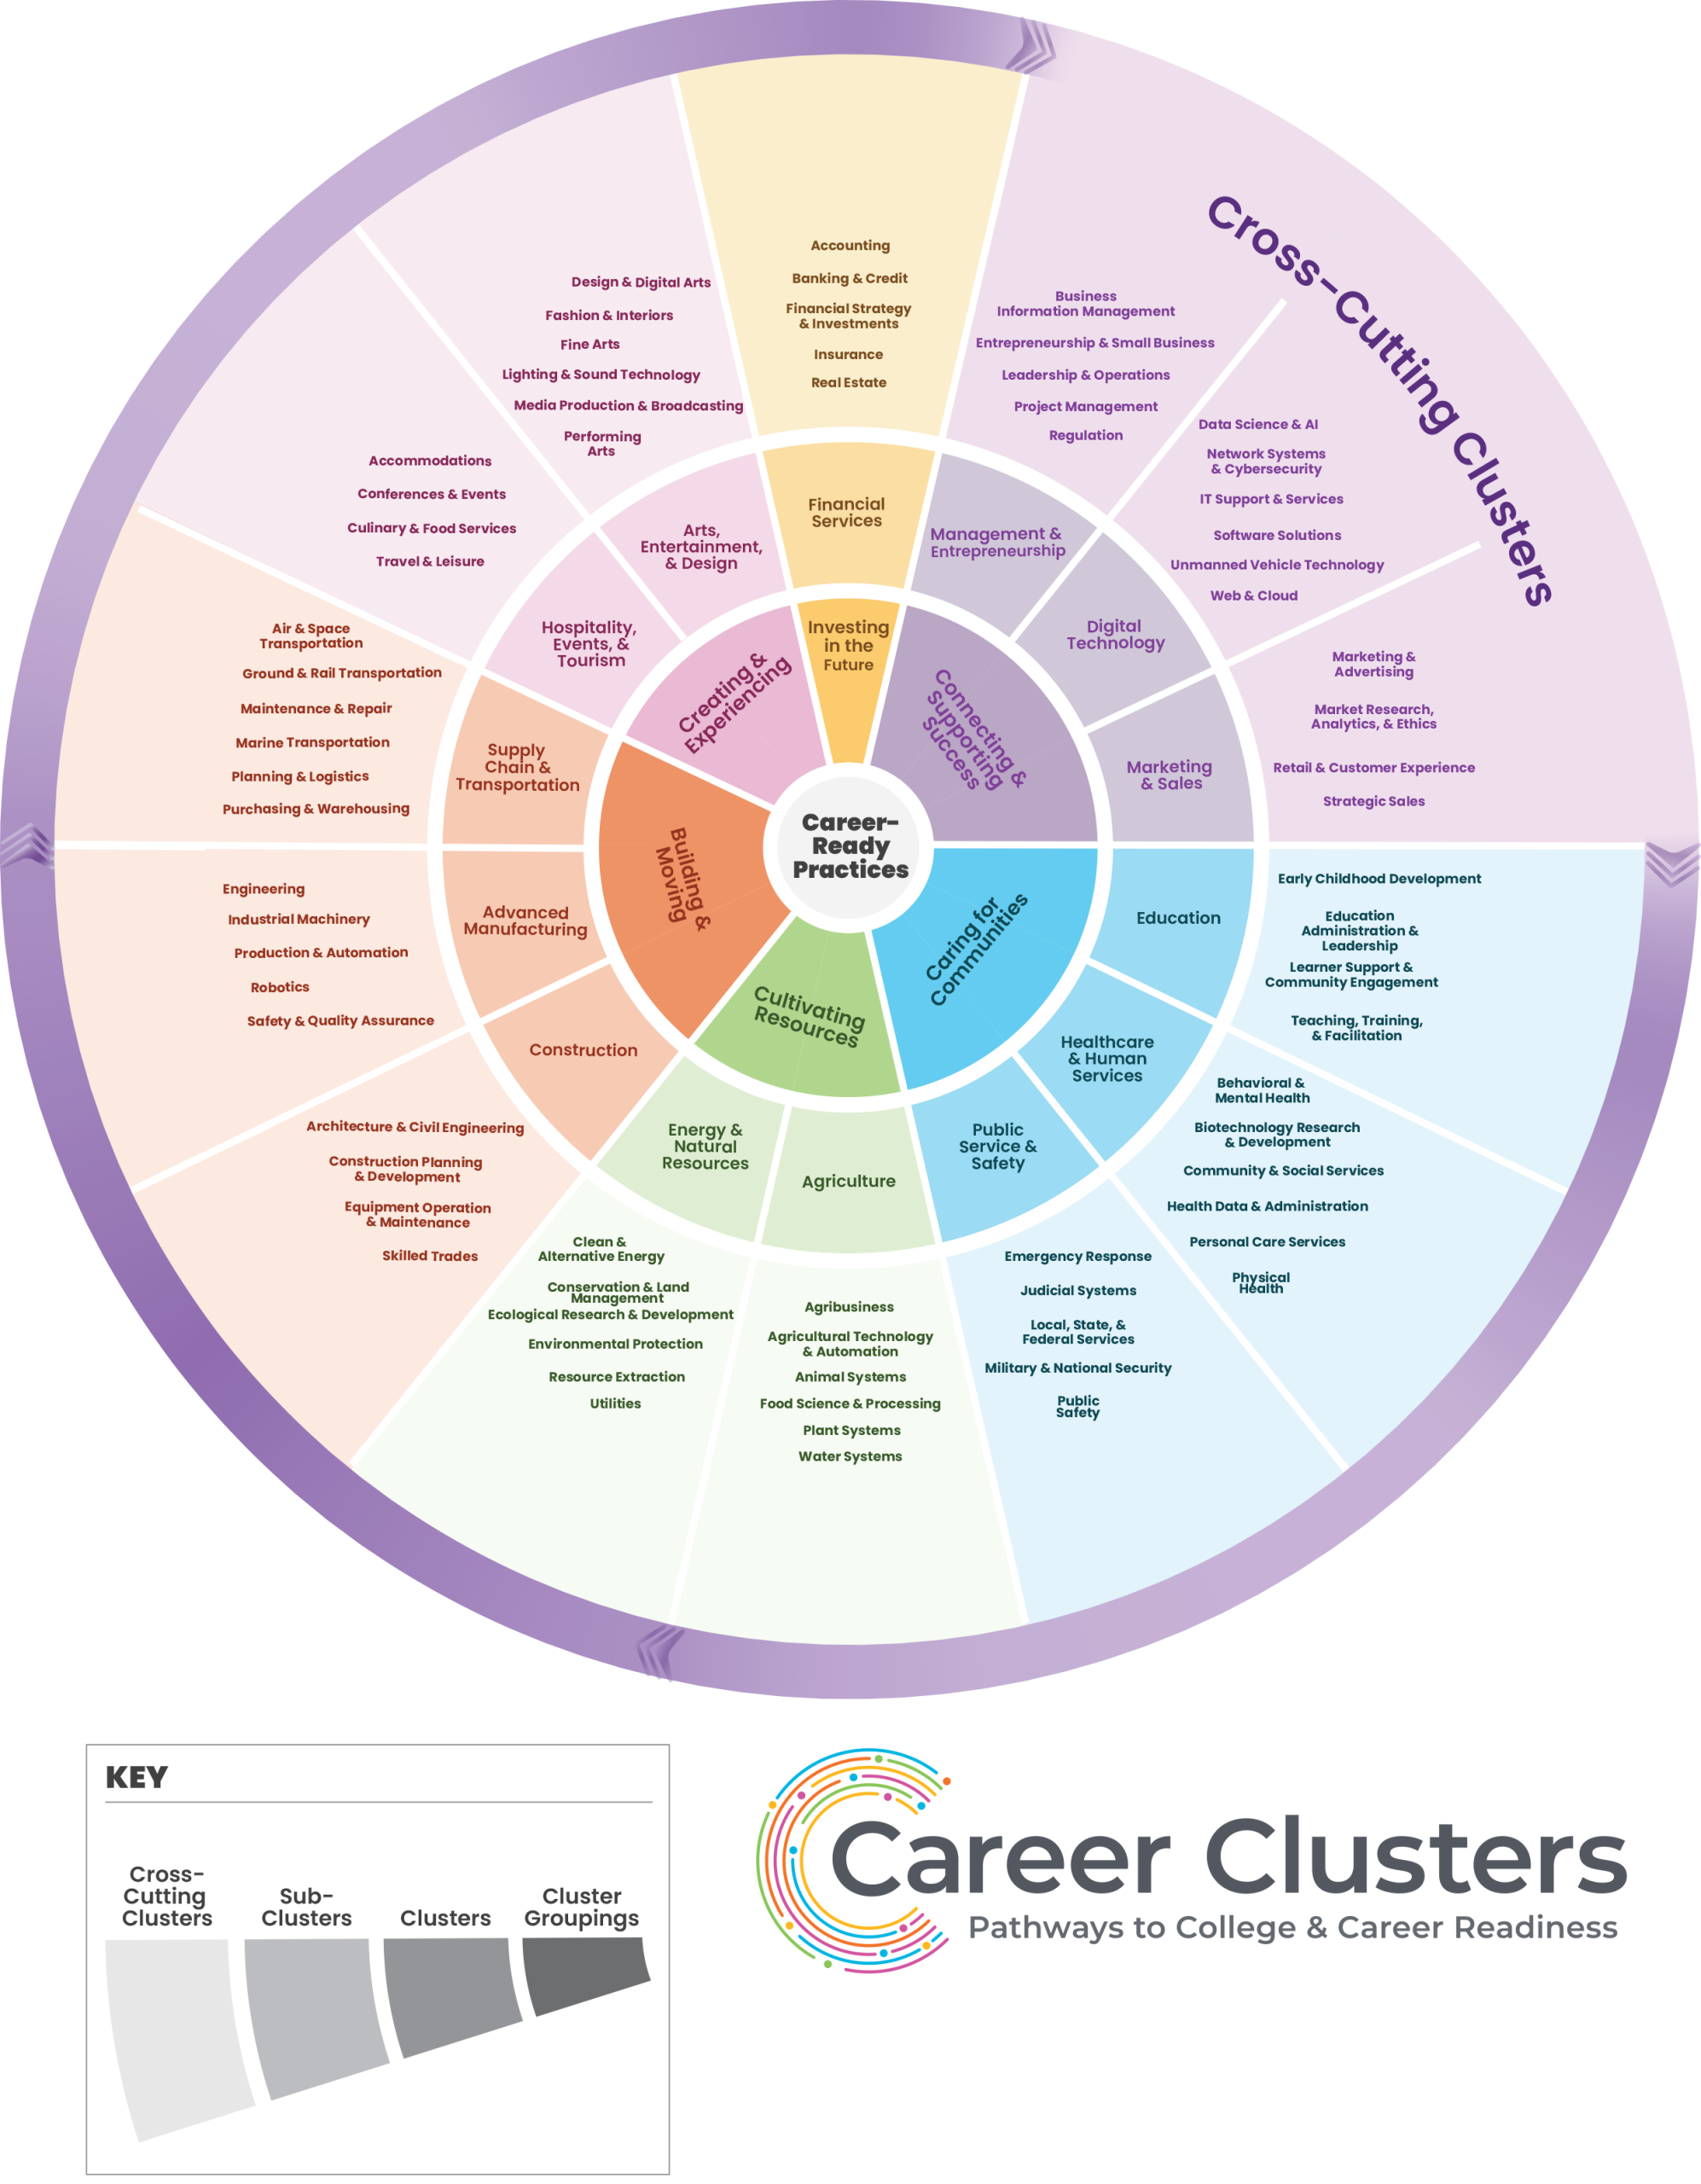

In [3]:
# Displaying the National Career Cluster Framework

from IPython.display import Image, display
file_path = '/content/drive/MyDrive/_LPO/7500SPED_NLP/Proj/CareerClustersWheel-key-1-scaled.png'
display(Image(filename=file_path, width=400))

In [6]:
# Generating the 6 coarsened NCCF occupational groups from the 24 fine-grained Category tags
category_to_nccf = {
    # Building / Moving
    'ENGINEERING': 'Building_Moving',
    'CONSTRUCTION': 'Building_Moving',
    'AUTOMOBILE': 'Building_Moving',
    'AVIATION': 'Building_Moving',

    # Caring
    'HEALTHCARE': 'Caring',
    'TEACHER': 'Caring',
    'ADVOCATE': 'Caring',
    'FITNESS': 'Caring',

    # Connecting / Supporting
    'HR': 'Connecting_Supporting',
    'PUBLIC-RELATIONS': 'Connecting_Supporting',
    'CONSULTANT': 'Connecting_Supporting',
    'DIGITAL-MEDIA': 'Connecting_Supporting',
    'SALES': 'Connecting_Supporting',
    'BUSINESS-DEVELOPMENT': 'Connecting_Supporting',
    'BPO': 'Connecting_Supporting',
    'INFORMATION-TECHNOLOGY': 'Investing', # Added missing comma

    # Creating / Experiencing
    'ARTS': 'Creating_Experiencing',
    'DESIGNER': 'Creating_Experiencing',
    'CHEF': 'Creating_Experiencing',
    'APPAREL': 'Creating_Experiencing',

    # Cultivating
    'AGRICULTURE': 'Cultivating',

    # Investing
    'ACCOUNTANT': 'Investing',
    'BANKING': 'Investing',
    'FINANCE': 'Investing',
}

# Create the new NCCF column by mapping
resume_data['NCCF'] = resume_data['Category'].map(category_to_nccf)

In [7]:
# Printing descriptives for the coarsened NCCF occupational groups
group_descriptives = describe_categorical(resume_data, 'NCCF')
print("  ")

# Creating a binary marker for analysis indicating whether a resume is in either “Connecting_Supporting” or “Investing" as opposed to the other 4 groups hypothesized to have higher concreteness scores
resume_data['NCCF_binary'] = resume_data['NCCF'].isin(['Connecting_Supporting', 'Investing']).astype(int)
print("Binary macro-sector descriptives:")
print(resume_data['NCCF_binary'].describe())

Descriptive Statistics for 'NCCF' Variable:

Total Observations: 2484
Number of Unique Categories: 6
Missing Value Percentage: 0.00%

Category Counts:
NCCF
Connecting_Supporting    690
Investing                471
Caring                   452
Creating_Experiencing    425
Building_Moving          383
Cultivating               63
Name: count, dtype: int64
Median Category Count: 438.50

  
Binary macro-sector descriptives:
count    2484.000000
mean        0.467391
std         0.499036
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: NCCF_binary, dtype: float64


To prepare the data for analysis, I separate the single string variable with resume content in HTML format to create separate variables containing each major section of a resume (e.g., Summary, Education, Experiences, etc.). I create these separate variables from the string content of the HTML variable; I exploit HTML formatting to help identify the start and end of various resume resume sections using regular expressions.

I then generate a variable holding all data where individuals describe their professional experiences, skills, and successes by combining the all_exp_text variable with the summary, skills, and achievement variables. This variable, content_text, excludes resume sections like Education and Objective as these sections do not capture individual's applied skills, behaviors, and successes.

In [8]:
# Cleaning the data

# Define known section names using a dictionary of possible values for each key, capturing variation in how resumes are structured
section_names = {
    "summary": r"(summary|professional\s+summary|executive\s+summary|profile|about\s+me)",
    "objective": r"(objective|career\s+objective|career\s+goal)",
    "experience": r"(experience|work\s+experience|professional\s+experience|employment\s+history|work\s+history)",
    "education": r"(education|academic\s+background|educational\s+background|education\s+training|education\s+and\s+training|academic\s+history|training)",
    "skills": r"(skills|technical\s+skills|core\s+competencies|areas\s+of\s+expertise|proficiencies)",
    "projects": r"(projects|project\s+experience|relevant\s+projects|presentations|publications|papers)",
    "certifications": r"(certifications?|licenses?|accreditations?)",
    "achievements": r"(highlight|highlights|achievements?|awards|honors|recognition|accomplishments)"
    }

# Create a regex pattern that matches section headers
pattern = re.compile(r'\b(' + '|'.join(section_names) + r')\b', flags=re.IGNORECASE)

# Define a function to separate the resume html string into the separate sections defined in the dictionary above
def extract_sections_regex(html_text):
    if not isinstance(html_text, str) or not html_text.strip():
        return {name.lower(): None for name in section_names} # check that the variable holding all resume content is not empty or not a string (i.e., is there language text)

    # Convert HTML to plain text
    text = BeautifulSoup(html_text, "html.parser").get_text(separator="\n")
    text = re.sub(r'\s+', ' ', text).strip() # strip out extra spaces

    # Identify section headers
    matches = list(pattern.finditer(text)) # call the pattern from line 16 (section names and breaks)
    sections = {name.lower(): None for name in section_names} # creates each section; default to empty, with text strings added if the section is found

    if not matches:
        return sections

    for i, match in enumerate(matches):
        section_name = match.group(1).lower()
        start = match.end() # start the text corresponding to a section header right after the header ends (i.e. the first word after "Education")
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text) # defines the end of one section as one character before the start of another section
        content = text[start:end].strip() # pulls all text between the start and end indices for the named section
        if len(content) > 2: # length check to ensure the section isn't unreasonably short
            sections[section_name] = content

    return sections

# Running the function to separate the resume string into separate variables for each section of the resume
resume_separated = resume_data['Resume_html'].apply(extract_sections_regex).apply(pd.Series)

# Merge the results (separated columns) back into the main DataFrame
resume_clean = pd.concat([resume_data, resume_separated], axis=1)

# Dropping the raw string and html columns so that only the separated section variables remain
resume_clean = resume_clean.drop(columns=['Resume_html'])

# Save; visually inspect results
resume_clean.to_csv("resume_separated.csv", index=False)
# print(resume_clean.filter(regex="Experience").head())

In [9]:
# Describing missingness for the resume section variables generated above

for col in ["summary", "objective", "experience", "education", "skills", "projects", "certifications", "achievements"]:
   print(f"Missingness for {col}")
   missing_pct_col = resume_clean[col].isna().mean() * 100
   print(f"Missing Value Percentage: {missing_pct_col:.2f}%\n")

Missingness for summary
Missing Value Percentage: 25.48%

Missingness for objective
Missing Value Percentage: 95.69%

Missingness for experience
Missing Value Percentage: 3.22%

Missingness for education
Missing Value Percentage: 1.93%

Missingness for skills
Missing Value Percentage: 1.33%

Missingness for projects
Missing Value Percentage: 57.81%

Missingness for certifications
Missing Value Percentage: 84.26%

Missingness for achievements
Missing Value Percentage: 94.97%



In [10]:
# Joining all variables containing active descriptions of individuals' skills, behaviors, and successes. This is the focal variable for the following analysis.

resume_clean["content_text"] = (
    resume_clean[["experience", "summary", "skills", "achievements"]]
    .fillna("")  # Replace NaN with empty string
    .agg(" ".join, axis=1)
    .str.strip())

In [11]:
# Checking for missingness at the content_text variable stage

missing_count = resume_clean['content_text'].isnull().sum()

print(f"Number of missing values in content_text: {missing_count}") # Print to confirm if no missingness

Number of missing values in content_text: 0


*2.2 Data Descriptives: Sample balance and missingness*

As the mean value of *NCCF_binary* is 0.47, the sample is very nearly evenly balanced between the two groups I hypothesize may have differentiating TF-IDF values. As such, I do not need to randomly sample from within one group to create equivalently-sized samples; I will proceed with the full dataset.

Given the nature of resumes, we expect NaN values to occur for some sections--but not for others. By defintion, resumes should have job experience and education data, but may or may not include summaries, objective statements, certifications, skills, projects, or the like. The above missingness assessment largely meets this assumption, suggesting cleaning was successful. Missingness is very low -- under 4% -- for education, experience, and skills. Missingness is high for atypical resume sections, like certifications and achievements. Resumes do not have a set number of job experiences. The number of experiences listed--the number of job transitions--is influenced by a multitude of factors, such as the individuals' years of work experience, levels of promotion and turnover in their industry, individual desire to change role (influenced by working conditions, potential for advancement, etc.), and organizational or structural factors (e.g., downsizing, economic contractions, etc.).

**3 NLP Analysis**

To prepare for the TF-IDF analysis, I first process the cleaned text. I eliminate stop words to restrict the TF-IDF analysis to more content-rich words. I then define the bag-of-words corpus and generate a dataframe using this corpus to prepare for the term frequency, inverse document frequency, and TF-IDF value calculations. I estimate logistic regression models using these TF-IDF values to predict whether resumes belong in the specialized macro-sector (NCCF_binary=0) or the cross-cutting macro-sector (NCCF_binary=1).

In [12]:
# Process focal variable generated above for using spaCy to enable NLP analysis

data_docs = list(nlp.pipe(resume_clean.content_text)) #run spaCy on the column with the content-rich resume sections

# Defining a function to keep only content-rich words from the text AND reduce these words to their lemmas
def get_words(docs):
    tokens = []
    for token in docs:
        if not token.is_punct and not token.is_space and not token.is_stop and token.is_alpha: # removes stopwords, punctuations, spaces, and numerics
          tokens.append(token.lemma_.lower()) # lowercases and lemmatizes
    return tokens

# Restricting sample to content-rich words and lemmatizing using the above function
processed_docs = [get_words(doc) for doc in data_docs]

In [36]:
# Language data descriptives
lemma_counts = [len(doc) for doc in processed_docs] # number of words after processing
resume_clean['lemma_counts'] = lemma_counts

# Overall language data descriptives
print(f"Mean post-processing lemmas per resume: {np.mean(lemma_counts):.4f}")
print(f"Std deviation: {np.std(lemma_counts):.2f}")
print(f"Min: {np.min(lemma_counts):.2f}")
zero_lemma_count = np.sum(np.array(lemma_counts) == 0)
print(f"Number of resumes with 0 lemmas after processing: {zero_lemma_count}")
lemma_counts_array = np.array(lemma_counts) # sorting to get minimum value > 0
min_greater_than_zero = np.min(lemma_counts_array[lemma_counts_array > 0]) if np.any(lemma_counts_array > 0) else None
print(f"Min (excluding 0): {min_greater_than_zero:.2f}")
print(f"Max: {np.max(lemma_counts):.2f}")
max_lemma_count = np.sum(np.array(lemma_counts) > 3000)
print(f"Number of resumes with more than 3,000 lemmas after processing: {max_lemma_count}")
print("")

# Differences in average experience section length by cluster group and macro-sector
lemmas_by_group = resume_clean.groupby("NCCF")["lemma_counts"].mean().sort_values(ascending=False) # 6 cluster groups
print("Lemmas per content-rich resume subsample by NCCF cluster group:")
print(lemmas_by_group)
print("")

lemmas_by_binary = resume_clean.groupby("NCCF_binary")["lemma_counts"].mean().sort_values(ascending=False) # 2 macro-sectors
print("Lemmas per content-rich resume subsample by macro-sector:")
print(lemmas_by_binary)
print("")

# Testing the statistical and practical significance of the above difference in means; separating data based on NCCF_binary grouping
cc_lemmas = resume_clean[resume_clean['NCCF_binary'] == 1]['lemma_counts']
disc_lemmas = resume_clean[resume_clean['NCCF_binary'] == 0]['lemma_counts']

# Means and standard deviations by macro-sector
mean1, mean2 = disc_lemmas.mean(), cc_lemmas.mean()
std1, std2 = disc_lemmas.std(), cc_lemmas.std()

# Statistical significance testing for difference in lemmas: t-test
t_result = stats.ttest_ind(disc_lemmas, cc_lemmas)
print("Statistical and practical significance:")
print(f"  T-statistic: {t_result.statistic:.3f}")
print(f"    P-value: {t_result.pvalue:.3f}")

# Compute pooled standard deviation
n1, n2 = len(disc_lemmas), len(cc_lemmas)
pooled_std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))

# Practical significance testing: Cohen's d
cohen_d = (mean1 - mean2) / pooled_std

print(f"  Cohen's d: {cohen_d:.3f}")

Mean post-processing lemmas per resume: 233.3756
Std deviation: 185.18
Min: 0.00
Number of resumes with 0 lemmas after processing: 1
Min (excluding 0): 1.00
Max: 3358.00
Number of resumes with more than 3,000 lemmas after processing: 1

Lemmas per content-rich resume subsample by NCCF cluster group:
NCCF
Investing                267.286624
Connecting_Supporting    257.398551
Creating_Experiencing    220.771765
Building_Moving          209.096606
Cultivating              204.634921
Caring                   197.796460
Name: lemma_counts, dtype: float64

Lemmas per content-rich resume subsample by macro-sector:
NCCF_binary
1    261.409991
0    208.773998
Name: lemma_counts, dtype: float64

Statistical and practical significance:
  T-statistic: -7.137
    P-value: 0.000
  Cohen's d: -0.287


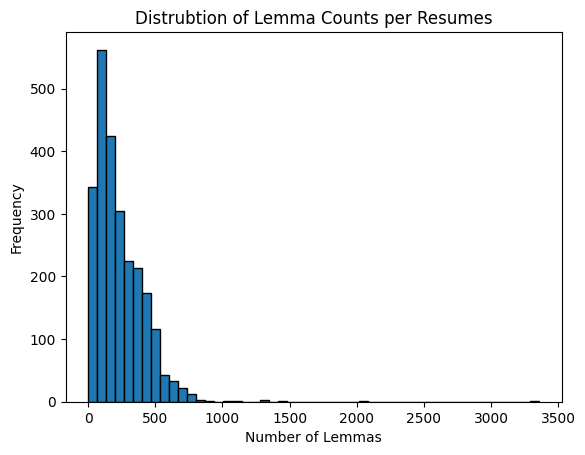

In [21]:
# Distribution of language data
plt.hist(lemma_counts, bins=50, edgecolor='black')
plt.xlabel("Number of Lemmas")
plt.ylabel("Frequency")
plt.title("Distrubtion of Lemma Counts per Resumes")
plt.show()

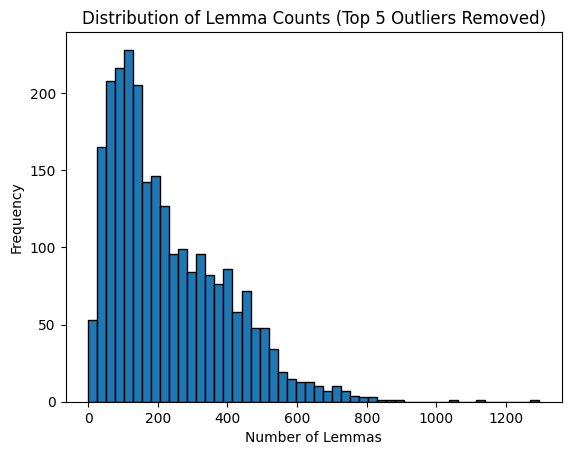

In [22]:
# Re-visualizing after excluding outliers
trimmed_lemma_counts = list(lemma_counts)
trimmed_lemma_counts.sort()
trimmed_lemma_counts = trimmed_lemma_counts[:-5]

plt.hist(trimmed_lemma_counts, bins=50, edgecolor='black')
plt.xlabel("Number of Lemmas")
plt.ylabel("Frequency")
plt.title("Distribution of Lemma Counts (Top 5 Outliers Removed)")
plt.show()

In [23]:
# Identifying excluded outlier values
sorted_lemma_counts = sorted(lemma_counts, reverse=True)
print("Top 5 lemma_counts values:")
for i in range(5):
    print(f"Rank {i+1}: {sorted_lemma_counts[i]}")

Top 5 lemma_counts values:
Rank 1: 3358
Rank 2: 2055
Rank 3: 1414
Rank 4: 1342
Rank 5: 1312


After processing, the average overall length of the content-rich resume sections (summary, experience, accomplishments, skills) is 213 words. The standard deviation for this subset of the overall resume is 188. Importantly, this length has already been reduced to lemmas.

In [24]:
# Checking for missingness at the processed_docs stage (i.e., cleaned and lemmatized text data)

none_count = sum(1 for item in processed_docs if item is None or item == '' or (isinstance(item, float) and np.isnan(item)))
pct = (none_count / len(processed_docs)) * 100 if len(processed_docs) > 0 else 0
print(f"Missing/None items: {none_count}/{len(processed_docs)} ({pct:.1f}%)")

Missing/None items: 0/2484 (0.0%)


In [25]:
# Preparing for the TF-IDF analysis by creating the bag-of-words corpus from the processed resume data using Gensim and generating the BOW dataframe.

dictionary = gensim.corpora.Dictionary() # empty dictionary to store values for the bag of words

bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in processed_docs] # add each resume to the bag of words corpus

print(f'number of texts: {len(bow_corpus)}') # number of texts
print(f'number of lemmas: {len(dictionary)}') # number of words

vocab = pd.Series(dictionary.token2id).index # get lemmas from BOW dictionary
index = range(len(bow_corpus))

bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float16), # creating dataframe full of zeros to store BOW data
                  index=index, # row labels
                  columns=vocab) # column labels

for idx in index: # Add each word from the BOW corpus to the dataframe
  for id, freq in bow_corpus[idx]:
    bow_df.loc[idx,dictionary[id]] = freq

# bow_df

number of texts: 2484
number of lemmas: 20363


In [26]:
# Checking missingness at the column (i.e., word) level after generating BOW dataframe

for col in bow_df.columns:
  missing_pct_col = bow_df[col].isna().mean() * 100
  if missing_pct_col > 0:
    print(f"Missingness for {col}: {missing_pct_col:.2f}%\n") # naming variable

In [27]:
# Checking missingness at the resume level after generating BOW dataframe

missing_per_row = bow_df.isnull().sum(axis=1)

print(f"Total rows: {len(bow_df)}")
print(f"Rows with no missing values: {(missing_per_row == 0).sum()}")
print(f"Rows with at least one missing value: {(missing_per_row > 0).sum()}")
print(f"Rows completely missing (all NaN): {(missing_per_row == len(bow_df.columns)).sum()}")

Total rows: 2484
Rows with no missing values: 2484
Rows with at least one missing value: 0
Rows completely missing (all NaN): 0


*3.1 TF-IDF*

I assess the relative import of the terms in resumes across different career sectors by generating TF-IDF values and using those values to predict macro-sector. As such, I first assess how frequently words appear within a single resume (TF) and then how frequently those same words appear across all other resumes in the dataframe (IDF). High TF-IDF values signal words that are frequent within a specific resume but rare across the entire dataframe of resumes, with lower values indicating words that are either frequently used across documents or rarely used within documents.


In [28]:
# Generate inverse document frequency values

num_documents = len(bow_df) #get the length of the documents

def idf(term):
  documents_containing_term = (bow_df[term] > 0).sum()
  return np.log(num_documents / (documents_containing_term + 1))
idf = pd.Series({term:idf(term) for term in bow_df.columns})

# print("idf values in descending order:")
# print(idf.sort_values(ascending=False))

In [29]:
# Checking missingness after generating IDF values
missing_count_idf = idf.isna().sum()
print("Column-Level Missingness Summary of IDF Values")
print(f"Total missing values: {missing_count}")
print(f"Total terms: {len(idf)}")
print(f"Percentage missing: {(missing_count / len(idf) * 100):.2f}%\n")

# IDF descriptives
print("IDF Descriptives:")
print(idf.describe())
print()

Column-Level Missingness Summary of IDF Values
Total missing values: 0
Total terms: 20363
Percentage missing: 0.00%

IDF Descriptives:
count    20363.000000
mean         6.304305
std          1.231358
min          0.185224
25%          5.871715
50%          6.719013
75%          7.124478
max          7.124478
dtype: float64



In [30]:
# Generate term frequencies
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')
#tf_df

In [32]:
# Checking missingness after generating TF values
missing_per_row = tf_df.isnull().sum(axis=1) # measure of the missingness within a row
missing_rows = resume_clean[resume_clean.isnull().any(axis=1)] # binary flag for any missingness within the row

print("Row-Level Missingness Summary of TF Values")
print(f"Total rows: {len(tf_df)}")
print(f"Rows with no missing values: {(missing_per_row == 0).sum()}")
print(f"Rows with at least one missing value: {(missing_per_row > 0).sum()}")
print(f"Rows completely missing (all NaN): {(missing_per_row == len(tf_df.columns)).sum()}")

print("")
print("Resumes with TF Missingness")
for idx, count in missing_per_row.items():
    if count > 0:
        print(f"\nRow {idx} has {count} missing value(s)")
        print(f"\nRow {idx} is in category {resume_clean.loc[idx, 'Category']}")

Row-Level Missingness Summary of TF Values
Total rows: 2484
Rows with no missing values: 2483
Rows with at least one missing value: 1
Rows completely missing (all NaN): 1

Resumes with TF Missingness

Row 656 has 20363 missing value(s)

Row 656 is in category BUSINESS-DEVELOPMENT


In [33]:
# Dropping resumes with missingness from the TF dataframe so that the logistic regression later on will run
tf_df = tf_df.dropna()

In [35]:
# TF descriptives
print("TF Descriptives:")
tf_values = tf_df.values.flatten()
print(f"Total values: {len(tf_values):,}")
print(f"Total values: {len(tf_values):,}")
print(f"Mean TF: {tf_values.mean():.6f}")
print(f"Std deviation: {tf_values.std():.6f}")
print(f"Min TF: {tf_values.min():.6f}")
print(f"Max TF: {tf_values.max():.6f}")

print("")
print("Non-zero TF Descriptives:")
non_zero_tf = tf_values[tf_values > 0]
non_zero_tf = non_zero_tf[~np.isnan(non_zero_tf)]
print(f"Count of non-zero values: {len(non_zero_tf):,}")
print(f"Percentage non-zero: {(len(non_zero_tf) / len(tf_values) * 100):.2f}%")
print(f"Mean TF (non-zero): {non_zero_tf.mean():.6f}")
print(f"Std dev (non-zero): {non_zero_tf.std():.6f}")
print(f"Min TF (non-zero): {non_zero_tf.min():.6f}")
p25 = pd.Series(non_zero_tf).quantile(0.25)
p50 = pd.Series(non_zero_tf).quantile(0.50)
p75 = pd.Series(non_zero_tf).quantile(0.75)
print(f"25th percentile: {p25:.6f}")
print(f"50th percentile: {p50:.6f}")
print(f"75th percentile: {p75:.6f}")
print(f"Max TF (non-zero): {non_zero_tf.max():.6f}")

print("")
print("Resumes with TF==1")
docs_with_tf_1 = (tf_df == 1).any(axis=1)
doc_indices = docs_with_tf_1[docs_with_tf_1].index.tolist()
print(f"Total documents with TF=1: {len(doc_indices)}")
print(f"Document indices: {doc_indices}")
for idx in doc_indices:
    print(f"Row {idx} is in category {resume_clean.loc[idx, 'Category']}")

TF Descriptives:
Total values: 50,561,329
Total values: 50,561,329
Mean TF: 0.000049
Std deviation: 0.000810
Min TF: 0.000000
Max TF: 1.000000

Non-zero TF Descriptives:
Count of non-zero values: 354,425
Percentage non-zero: 0.70%
Mean TF (non-zero): 0.007004
Std dev (non-zero): 0.007504
Min TF (non-zero): 0.000298
25th percentile: 0.002785
50th percentile: 0.004761
75th percentile: 0.008400
Max TF (non-zero): 1.000000

Resumes with TF==1
Total documents with TF=1: 1
Document indices: [609]
Row 609 is in category BUSINESS-DEVELOPMENT


Resume 656 has completely missing term frequency values. This doesn’t really make sense, because there was no missingness when generating the content-rich text column, processing that text through the NLP pipeline, or creating the BOW data frame. As the logistic regression will not run with missing values, I drop this observation.

Additionally, resume 609 has a term frequency value of 1. This is problematic as it means that the entire resume has only one word. While I had checked for unreasonably short sections when identifying resume sub-sections, I removed content words and lemmatized in the data processsing stage. I also drop this observation to eliminate unreasonable TF values.

In [101]:
# Dropping resumes with TF=1 values
tf_df = tf_df.drop(doc_indices)

# Dropping corresponding resumes from the cleaned resume dataframe so that the resumes have the same number of observations when re-merged later on
rows_to_drop = [609, 656]
resume_clean = resume_clean.drop(index=rows_to_drop)

In [102]:
# Generate TF-IDF matrix
tfidf_df = tf_df.copy().multiply(idf, axis='columns')

#print("TF-IDF Matrix:")
#display(tfidf_df) # Display the TF-IDF dataframe

In [103]:
# Checking missingness after generating TF-IDF values
missing_per_row = tfidf_df.isnull().sum(axis=1)

print("Row-Level Missingness Summary of TF-IDF Dataframe")
print(f"Total rows: {len(tfidf_df)}")
print(f"Rows with no missing values: {(missing_per_row == 0).sum()}")
print(f"Rows with at least one missing value: {(missing_per_row > 0).sum()}")
print(f"Rows completely missing (all NaN): {(missing_per_row == len(tfidf_df.columns)).sum()}")

# TF-IDF descriptives
print("")
print("TF-IDF Descriptives:")
all_tfidf_values = tfidf_df.values.flatten()
print(f"Total values: {len(all_tfidf_values):,}")
print(f"Mean TF-IDF: {all_tfidf_values.mean():.6f}")
print(f"Std deviation: {all_tfidf_values.std():.6f}")
print(f"Min TF-IDF: {all_tfidf_values.min():.6f}")
print(f"Max TF-IDF: {all_tfidf_values.max():.6f}\n")

print("Non-zero TF-IDF Descriptives:")
non_zero_tfidf = all_tfidf_values[all_tfidf_values > 0]
print(f"Count of non-zero values: {len(non_zero_tfidf):,}")
print(f"Percentage non-zero: {(len(non_zero_tfidf) / len(all_tfidf_values) * 100):.2f}%")
print(f"Mean TF-IDF (non-zero): {non_zero_tfidf.mean():.6f}")
print(f"Std dev (non-zero): {non_zero_tfidf.std():.6f}")
print(f"Min TF-IDF (non-zero): {non_zero_tfidf.min():.6f}")
print(f"25th percentile: {np.percentile(non_zero_tfidf, 25):.6f}")
print(f"50th percentile: {np.percentile(non_zero_tfidf, 50):.6f}")
print(f"75th percentile: {np.percentile(non_zero_tfidf, 75):.6f}")
print(f"Max TF-IDF (non-zero): {non_zero_tfidf.max():.6f}\n")

Row-Level Missingness Summary of TF-IDF Dataframe
Total rows: 2482
Rows with no missing values: 2482
Rows with at least one missing value: 0
Rows completely missing (all NaN): 0

TF-IDF Descriptives:
Total values: 50,540,966
Mean TF-IDF: 0.000129
Std deviation: 0.002377
Min TF-IDF: 0.000000
Max TF-IDF: 1.184678

Non-zero TF-IDF Descriptives:
Count of non-zero values: 354,424
Percentage non-zero: 0.70%
Mean TF-IDF (non-zero): 0.018465
Std dev (non-zero): 0.021612
Min TF-IDF (non-zero): 0.000226
25th percentile: 0.007000
50th percentile: 0.012204
75th percentile: 0.021919
Max TF-IDF (non-zero): 1.184678



In [104]:
# Add the macro-sector columns to the TF-IDF dataframe
for col in ["NCCF_binary", "NCCF"]:
  tfidf_df[col] = resume_clean[col]

# calculate the mean TF-IDF value for each word per macro-sector
# The numeric_only=True argument is added to ensure that only numeric columns are included in the mean calculation.
mean_tfidf_by_binary = tfidf_df.groupby('NCCF_binary').mean(numeric_only=True)

# get top 10 words for each macro-sector based on means
top_words_binary = {} # dictionary
for binary_value in mean_tfidf_by_binary.index: # go through mean values
    top_words = mean_tfidf_by_binary.loc[binary_value].sort_values(ascending=False).head(10) # organize by top 10
    top_words_binary[binary_value] = top_words # send to dictionary

# Get top words for each macro-sector
top_words_0 = top_words_binary[0].reset_index() # field-specific sectors
top_words_0.columns = ['Word_0', 'TF-IDF_0']

top_words_1 = top_words_binary[1].reset_index() # cross-cutting business sectors
top_words_1.columns = ['Word_1', 'TF-IDF_1']

# Combine into a single DataFrame with columns side by side
side_by_side = pd.concat([top_words_0, top_words_1], axis=1)
display(side_by_side)

# Get top words for each cluster group

tfidf_df = tfidf_df.drop('NCCF_binary', axis=1) # dropping macro-sector variable to not include that variable when identifying top words in each of the 6 cluster groups

# Calculate the mean TF-IDF value for each word per NCCF
mean_tfidf_by_nccf = tfidf_df.groupby('NCCF').mean(numeric_only=True)

# Get top 10 words for each NCCF group
top_words_nccf = {}
for nccf_value in mean_tfidf_by_nccf.index:
    top_words = mean_tfidf_by_nccf.loc[nccf_value].sort_values(ascending=False).head(10)
    top_words_nccf[nccf_value] = top_words

# Create individual DataFrames for each NCCF group
nccf_dfs = []
for i, nccf_value in enumerate(sorted(top_words_nccf.keys())):
    temp_df = top_words_nccf[nccf_value].reset_index()
    temp_df.columns = [f'Word_{nccf_value}', f'TF-IDF_{nccf_value}']
    nccf_dfs.append(temp_df)

# Combine all NCCF groups side by side
nccf_side_by_side = pd.concat(nccf_dfs, axis=1)
print("\nTop 10 Words by NCCF:")
display(nccf_side_by_side)

,Word_0,TF-IDF_0,Word_1,TF-IDF_1
0,teacher,0.006490,financial,0.008890
1,customer,0.006483,marketing,0.007611
2,student,0.006473,sale,0.007469
3,construction,0.006434,business,0.006756
4,patient,0.006145,accounting,0.006520
5,design,0.005951,account,0.006466
6,food,0.005473,customer,0.006438
7,safety,0.005198,client,0.006051
8,project,0.004904,employee,0.005065
9,engineering,0.004773,hr,0.004995



Top 10 Words by NCCF:


,Word_Building_Moving,TF-IDF_Building_Moving,Word_Caring,TF-IDF_Caring,Word_Connecting_Supporting,TF-IDF_Connecting_Supporting,Word_Creating_Experiencing,TF-IDF_Creating_Experiencing,Word_Cultivating,TF-IDF_Cultivating,Word_Investing,TF-IDF_Investing
0,construction,0.020157,teacher,0.014307,marketing,0.010858,food,0.014769,agriculture,0.015963,financial,0.017971
1,engineering,0.014208,patient,0.014232,sale,0.009362,chef,0.011709,student,0.010186,accounting,0.013710
2,project,0.009459,fitness,0.010951,hr,0.007752,design,0.011088,research,0.008890,tax,0.009678
3,repair,0.008602,child,0.010233,customer,0.007712,designer,0.011026,program,0.006758,finance,0.009611
4,aircraft,0.008584,student,0.010102,medium,0.007616,kitchen,0.008241,agricultural,0.006551,account,0.009467
5,safety,0.008450,customer,0.008151,business,0.007061,customer,0.006696,plant,0.006482,accountant,0.008391
6,engineer,0.008162,medical,0.007619,client,0.006568,cook,0.006616,visible,0.006316,bank,0.007878
7,equipment,0.008092,care,0.007388,employee,0.006537,student,0.006590,project,0.005801,analysis,0.007346
8,aviation,0.007755,lesson,0.007361,public,0.006045,graphic,0.006426,water,0.005790,reconciliation,0.007165
9,maintenance,0.007708,health,0.007174,strategy,0.005810,art,0.006274,development,0.005751,statement,0.007038


In [105]:
# Checking for repeated words across the 2 macro-sectors and 6 cluster groups

# Macro-Sector
# Collect all top words from each group
binary_top_words = {}
for binary_value in sorted(top_words_binary.keys()):
    binary_top_words[binary_value] = list(top_words_binary[binary_value].index)

# Find words that appear in multiple groups
from collections import Counter

# Flatten all words into a single list
all_words_flat = []
for words in binary_top_words.values():
    all_words_flat.extend(words)

# Count occurrences of each word
word_counts = Counter(all_words_flat)

# Find words that appear in more than one group
repeated_binary_words = {word: count for word, count in word_counts.items() if count > 1}

print("Top Words Appearing in Binary Groups:")

if repeated_binary_words:
    for word, count in sorted(repeated_binary_words.items(), key=lambda x: x[1], reverse=True):     # Sort by frequency (most repeated first)
        print(f"\n'{word}' appears in {count} groups:")
        for binary_value, words in binary_top_words.items():
            if word in words:
                tfidf_score = top_words_binary[binary_value][word]
                print(f"  - {binary_value}: TF-IDF = {tfidf_score:.4f}")


# Cluster Groups
# Collect all top words from each group
all_top_words = {}
for nccf_value in sorted(top_words_nccf.keys()):
    all_top_words[nccf_value] = list(top_words_nccf[nccf_value].index)

# Find words that appear in multiple groups
from collections import Counter

# Flatten all words into a single list
all_words_flat = []
for words in all_top_words.values():
    all_words_flat.extend(words)

# Count occurrences of each word
word_counts = Counter(all_words_flat)

# Find words that appear in more than one group
repeated_words = {word: count for word, count in word_counts.items() if count > 1}

print("")
print("Top Words Appearing in Multiple Cluster Groups:")

if repeated_words:
    for word, count in sorted(repeated_words.items(), key=lambda x: x[1], reverse=True):     # Sort by frequency (most repeated first)
        print(f"\n'{word}' appears in {count} groups:")
        for nccf_value, words in all_top_words.items():
            if word in words:
                tfidf_score = top_words_nccf[nccf_value][word]
                print(f"  - {nccf_value}: TF-IDF = {tfidf_score:.4f}")

Top Words Appearing in Binary Groups:

'customer' appears in 2 groups:
  - 0: TF-IDF = 0.0065
  - 1: TF-IDF = 0.0064

Top Words Appearing in Multiple Cluster Groups:

'student' appears in 3 groups:
  - Caring: TF-IDF = 0.0101
  - Creating_Experiencing: TF-IDF = 0.0066
  - Cultivating: TF-IDF = 0.0102

'customer' appears in 3 groups:
  - Caring: TF-IDF = 0.0082
  - Connecting_Supporting: TF-IDF = 0.0077
  - Creating_Experiencing: TF-IDF = 0.0067

'project' appears in 2 groups:
  - Building_Moving: TF-IDF = 0.0095
  - Cultivating: TF-IDF = 0.0058



*3.2 Estimating Logistic Regression Models with TF-IDF values*

After generating the TF-IDF values and inspecting the top words for each macro-sector based on means, I estimate logistic regression models to predict the NCCF binary. I first drop this column as to not overfit by predicting using the outcome. I then merge this information back in to calculate accuracy scores (visually represented with the confusion matrix), testing how well the model differentiates between macro-sectors. I also separately assess recall and precision for predicting 0 outcomes, in addition to reporting overall accurary and the recall and precision for predicting 1 outcomes.

In [107]:
# Filtering the TF-IDF matrix for analysis; only including top 200 lemmas in each macro-sector. Including 200 lemmas for approximately the top 1% (1981 lemmas)

# get top 200 words for each macro-sector based on means
top_200_binary = {} # dictionary
for binary_value in mean_tfidf_by_binary.index: # go through mean values
    top_words = mean_tfidf_by_binary.loc[binary_value].sort_values(ascending=False).head(200) # organize by top 200
    top_200_binary[binary_value] = top_words # send to dictionary

# Get top words for each macro-sector
top_words_0_200 = top_200_binary[0].reset_index() # field-specific sectors
top_words_0_200.columns = ['Word_0', 'TF-IDF_0']

top_words_1_200 = top_200_binary[1].reset_index() # cross-cutting business sectors
top_words_1_200.columns = ['Word_1', 'TF-IDF_1']

# Collect all top words from each group
binary_top_words = {}
for binary_value in sorted(top_200_binary.keys()):
    binary_top_words[binary_value] = list(top_200_binary[binary_value].index)
# Print the number of values for each key
print("Number of words for each binary group:")
for key, values in binary_top_words.items():
    print(f"  Binary group {key}: {len(values)} words")
# Flatten the dictionary values into a single list
all_200_words = set()
for words in binary_top_words.values():
    all_200_words.update(words)

# Filter tfidf_df to only include these top words
columns_to_keep = [col for col in tfidf_df.columns if col in all_200_words]
tfidf_df_filtered = tfidf_df[columns_to_keep].copy() # Keep only the columns that are in top words list
print(f"Shape of tfidf_df_filtered: {tfidf_df_filtered.shape}")

Number of words for each binary group:
  Binary group 0: 200 words
  Binary group 1: 200 words
Shape of tfidf_df_filtered: (2482, 295)


Logistic Regression Accuracy: 0.7927565392354124
Logistic Regression Precision: 0.8295454545454546
Logistic Regression Recall: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       278
           1       0.83      0.67      0.74       219

    accuracy                           0.79       497
   macro avg       0.80      0.78      0.78       497
weighted avg       0.80      0.79      0.79       497



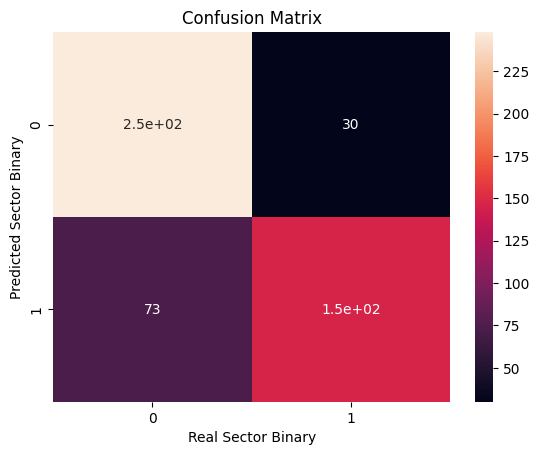

In [108]:
# Splitting data into training and testing sets for machine learning using TF-IDF features

from sklearn.model_selection import train_test_split # test-train package
seed = 42 # random seed

tf_idf = tfidf_df_filtered # only using the top 200 words from each macro-sector as to not overfit
prompt = resume_clean['NCCF_binary'] # predict the macro-sector binary feature

# the labels, or answers, we want to test against
tf_idf_train, tf_idf_test, prompt_train, prompt_test = train_test_split(tf_idf, prompt, test_size=0.2, random_state = seed)

# Estimating the training set
classifier = LogisticRegression() # Using a logistic regression classifier.
classifier.fit(tf_idf_train, prompt_train) #train on tf-idf values to prompt the macro-sector

# Predicting with the testing set
predicted = classifier.predict(tf_idf_test)# Model Accuracy

# Printing out metrics
print("Logistic Regression Accuracy:",metrics.accuracy_score(prompt_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(prompt_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(prompt_test, predicted))
print(metrics.classification_report(prompt_test, predicted)) # Print a classification report


# Printing incorrect predictions in a confusion matrix
cm = metrics.confusion_matrix(prompt_test, predicted)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Real Sector Binary')
plt.ylabel('Predicted Sector Binary')
plt.show()

Prediction accuracy for the full data is 0.80. When separating results by macro-sector, recall is higher for the more specialized sectors (grouped into NCCF_binary==0) than for the cross-cutting sectors (grouped into NCCF_binary==1). This means that the model catches more actual positives for the discrete macro-sector (89%) than the cross-cutting macro-sector (67%). Given that the dataset is very nearly balanced between the two groups, the confusion matrix visually represents this with the quadrant II value (250) being higher than the quadrant IV value (250). Below, I use the coefficient values to identify the terms which contribute the most to predicting either a 0 or 1 value (i.e., discrete or cross-cutting).

In [109]:
# Creating a dataframe with the coefficients from the ML model corresponding to the resume terms
coef_df = pd.DataFrame({'coefficients':list(classifier.coef_.flatten()), 'vocabulary': tf_idf.columns})

# take the lowest coefficients by sorting dataframe based on the coefficient values, with the lowest values (i.e, most negative) at the top
lowest = coef_df.sort_values(by='coefficients').head(20).reset_index(drop=True)
# resets the row index to start from 0.
lowest.columns = [col+'_prompt_1' for col in lowest.columns] #rename columns

# take the highest coefficients
highest = coef_df.sort_values(by='coefficients').tail(20).sort_values(by='coefficients', ascending=False).reset_index(drop=True)
highest.columns = [col+'_prompt_2' for col in highest.columns]

# put them together to compare
pd.concat([lowest, highest], axis=1)

,coefficients_prompt_1,vocabulary_prompt_1,coefficients_prompt_2,vocabulary_prompt_2
0,-2.097344,construction,2.526935,financial
1,-2.082569,teacher,1.867558,hr
2,-1.712019,patient,1.845170,account
3,-1.660393,engineering,1.784781,accounting
4,-1.657512,safety,1.673771,medium
5,-1.622923,food,1.643714,finance
6,-1.616997,designer,1.570446,business
7,-1.568632,fitness,1.450202,marketing
8,-1.426565,student,1.366733,tax
9,-1.417653,design,1.249035,public


The top 5 words for specialized sectors (i.e., 0 value) are construction, teacher, safety, patient, and engineering. These words are all intuitively linked to select career clusters within the macro-sector: education, healthcare, and building. The top 5 words for cross-cutting sectors are financial, hr, account, accounting, and medium. These are largely intuitive because they are terms used in various business settings (when “medium” is used to mean a mode of method of communication or messaging).

**4 Discussion**

Overall, the results support my hypotheses. TF-IDF values do differentiate between the two macro-sectors. Recall is higher for the macro-sector representing the more specific sectors of Building & Moving, Caring for Communities, Creating & Experiencing, and Cultivating Resources. The logistic regression model had higher recall (89%) for the discrete macro-sector than for the cross-cutting macro-sector (67%).

The difference between the precision and recall values when predicting 0 (discrete) or 1 (cross-cutting) macro-sectors is intuitive. The logistic regression model seems to lean towards labelling resumes as discrete. That is, the discrete macro-sector (0) has lower precision but higher recall than the cross-cutting macro-sector (1). Within the context of the data, there are key vocabulary terms that could explain this overproduction of 0s. The presence of individual words related to any of the fields contained within the discrete macro-sector, such as “chef,” “patient” or “teacher,” are highly predictive of actual positives for this sector and therefore would lead to few false negatives. However, words like “design” or “quality” could easily lead to false positives as these words could be used to describe physical design or quality work (0 outcome) or metaphorical design, like designing logistical systems (1 outcome). Top words for predicting 1 outcomes, such as business, strategy, and employee are understandably associated with lower recall values for 1 versus 0, as these words could also easily be used within resumes in discrete fields.

Overall, this outcome is predictable given the Career Cluster Framework itself. By defining the “cross-cutting” clusters as those fields which could be self-contained or could be embedded within other fields, they are less likely to be correctly identified than the discrete careers grouped into NCCF_binary==0.

*4.1 Limitations*

One significant limitation of these data is that I lack background and demographic characteristics for each resume (aside from the educational information contained in the resume, which could be used to infer age). Gender, race, SES, etc. are all missing and are highly relevant for individuals’ experiences in the labor market. Additionally, there are significant representativeness concerns stemming from the nature of the data. The data are not a representative sample of employed individuals, but rather were voluntarily uploaded by those seeking feedback. This introduces selection bias; resumes reflect only those preparing to switch roles, organizations, and/or fields. The dataset likely doesn’t include resumes for those who remain in a single role and/or organization throughout their career. As a result, there is likely an imbalance between fields, as some fields have more inter-organizational mobility than others; I may incorrectly assume that certain patterns describe field switching at large when, really, they describe field switching patterns common in the fields overrepresented in the data. Encouragingly, however, average variation in the length of resumes between fields is than the standard deviation for resume length overall. Lastly, the data likely include some jargon relevant to specific fields (a variety concern).

As I noted earlier on, my splicing of the *experience* variable resulted in the exclusion of potentially-relevant data. If resume formats systematically vary by field (that is, if select fields are less likely to list jobs by start-stop dates), my results would be systematically biased.

**5 References**

[1] AdvanceCTE 2024. Guidebook: The Modernized National Career Clusters Framework. AdvanceCTE.

[2]	Alsaif, S.A., Sassi Hidri, M., Ferjani, I., Eleraky, H.A. and Hidri, A. 2022. NLP-Based Bi-Directional Recommendation System: Towards Recommending Jobs to Job Seekers and Resumes to Recruiters. Big Data and Cognitive Computing. 6, 4 (Dec. 2022), 147. https://doi.org/10.3390/bdcc6040147.

[3]	Daryani, C., Chhabra, G.S., Patel, H., Chhabra, I.K. and Patel, R. 2020. An Automated Resume Screening System Using Natural Language Processing And Similarity. Ethics And Information Technology. 2, 2 (Jan. 2020), 99–103. https://doi.org/10.26480/etit.02.2020.99.103.

[4]	Pundir, R.S., Dhasmana, A., Karakoti, U., Sikder, A., Sharma, S. and Manchanda, M. 2024. Enhancing Resume Recommendation System through Skill-based Similarity using Deep Learning Models. 2024 International Conference on Inventive Computation Technologies (ICICT) (Lalitpur, Nepal, Apr. 2024), 557–562.

[5]	Rojas-Galeano, S., Posada, J. and Ordoñez, E. 2022. A Bibliometric Perspective on AI Research for Job-Résumé Matching. The Scientific World Journal. 2022, 1 (2022), 8002363. https://doi.org/10.1155/2022/8002363.

*5.1 Data Source*

*   https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset
*   Scraping code: https://github.com/Sbhawal/resumeScraper/tree/master

*5.2 Acknowledgement*

The cleaning code to prepare the data for this paper was refined with the assistance of ChatGPT (OpenAI, 2025). Analytical code was based on sample code from class. All writing and data decisionmaking (e.g., cleaning strategy, data visualization, etc.) were completed without the assistance of AI.

In [ ]:
# Alternate printing to avoid the cutoff in the File > Print output
%%capture

# Installing printing packages
!pip install nbconvert
!pip install pandoc

# Installing latex
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

# Printing
!jupyter nbconvert --to pdf "/content/drive/MyDrive/_LPO/7500SPED_NLP/Proj/DataAssign_TfIDF_KJM.ipynb" --output "/content/drive/MyDrive/_LPO/7500SPED_NLP/Proj/DataAssign_TfIDF_KJM.pdf"